In [1]:
%matplotlib inline
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import set_matplotlib_formats

# Plotting setup
# set_matplotlib_formats("pdf", "svg")
plt.rcParams["text.usetex"] = False
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsfonts} \usepackage{amsmath}"
from torch.autograd import Variable

import torch
import torch.nn as nn
import torch.nn.functional as F

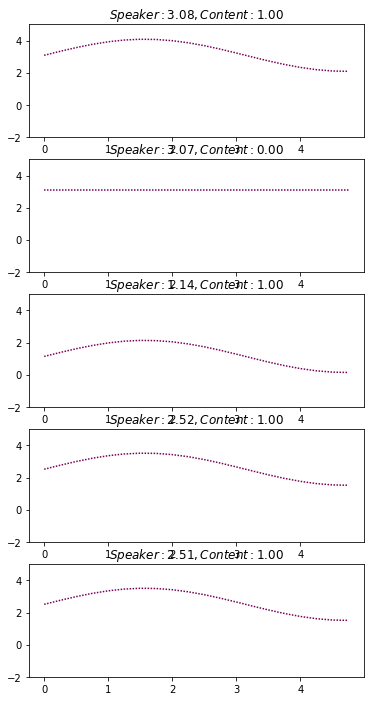

In [2]:

fig, axes = plt.subplots(nrows=5,ncols=1,figsize=(6,12))


xs = np.arange(0,5, .25)



training_samples = []
num_speakers = 5

# let's take some samples from our generative process
for speaker_id in range(num_speakers):
    content_factor = np.random.choice([-1,0,1])
    speaker_factor = np.random.normal(2, 1)
    y = content_factor * np.sin(xs) + speaker_factor
    training_samples.append(torch.unsqueeze(torch.unsqueeze(torch.Tensor(y), 0),0))
    axes[speaker_id].plot(xs, y,linestyle = (0, (1,1)), color = '#770058')
    axes[speaker_id].set_title(f'$Speaker: {speaker_factor:.2f}, Content: {content_factor:.2f}$')
    axes[speaker_id].set_ylim(-2,5)

plt.show()

We collected 100 samples


(-3, 3)

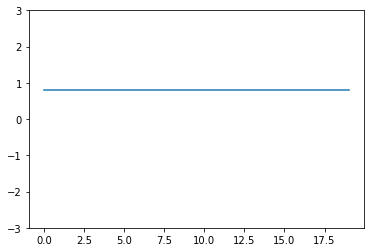

In [3]:
# Now, those are just some samples... Let's create a dataset from them
training_samples = []
for a in range(100):
    sentence_factor = np.random.choice([-1,0,1], 1)
    speaker_factor = np.random.choice(np.arange(0,2,0.2), 1)
    y = sentence_factor * np.sin(xs) + speaker_factor


    training_samples.append(torch.unsqueeze(torch.unsqueeze(torch.Tensor(y), 0),0))
    
print(f'We collected {len(training_samples)} samples')

plt.plot(training_samples[np.random.randint(0,99)][0][0].numpy())
plt.ylim(-3,3)

In [4]:



class FHVAE(nn.Module):
    def __init__(self):
        super(FHVAE, self).__init__()
        
        # encoder/inference
        
        # z2/sequence level
        self.lstm_z2 = nn.LSTM(20,30)
        self.mlp_mean_z2 = nn.Sequential(nn.Linear(30,20), nn.Tanh(),nn.Linear(20,20), nn.Tanh(), nn.Linear(20,1))
        self.mlp_std_z2 = nn.Sequential(nn.Linear(30,20), nn.Tanh(), nn.Linear(20,20), nn.Tanh(),nn.Linear(20,1))
        
        # z1/segment level
        self.lstm_z1 = nn.LSTM(21,30)
        self.mlp_mean_z1 = nn.Sequential(nn.Linear(30,20), nn.Tanh(), nn.Linear(20,10), nn.Tanh(), nn.Linear(10,1))
        self.mlp_std_z1 = nn.Sequential(nn.Linear(30,20), nn.Tanh(), nn.Linear(20,10), nn.Tanh(), nn.Linear(10,1))
        
        
        self.mu2_lookup = nn.Embedding(100, 1)
        
        # decoder/generative
        self.lstm_x = nn.LSTM(2,10)
        self.mlp_mean_x = nn.Sequential(nn.Linear(10,10), nn.ReLU(), nn.Linear(10,20))
        self.mlp_std_x = nn.Sequential(nn.Linear(10,10), nn.ReLU(), nn.Linear(10,20))

        
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps= torch.empty(mu.size()).normal_(mean=0,std=1)#.unsqueeze(0)
        
        return mu + eps*std
    
    
    def forward(self, x, sequence_id=None):
#         # encode

        # z2
        _, (h_z2, c_z2) = self.lstm_z2(x)
        mu_z2 = self.mlp_mean_z2(h_z2)
        std_z2 = self.mlp_std_z2(h_z2)
        
        z2 = self.reparameterize(mu_z2, std_z2)
        
        
        # z1
        _, (h_z1, c_z1) = self.lstm_z1(torch.cat((x.squeeze(), z2[0,0])).unsqueeze(0).unsqueeze(0))        
        mu_z1 = self.mlp_mean_z1(h_z1)
        std_z1 = self.mlp_std_z1(h_z1)   
        
        z1 = self.reparameterize(mu_z1, std_z1)
        
        # lookup table
        mu2 = self.mu2_lookup(sequence_id)

        
        # decode
        
        # form hidden state based on latent variables
        _, (h_x, c_x) = self.lstm_x(torch.cat((z1[0,0], z2[0,0])).unsqueeze(0).unsqueeze(0))
        # parameterize gaussian over reconstruction
        mu_x = self.mlp_mean_x(h_x)
        std_x =self.mlp_std_x(h_x)
        # sample a reconstruction
        x_reconstructed = self.reparameterize(mu_x, std_x)
                
        return (mu_x, std_x), (mu_z1,std_z1), (mu_z2,std_z2), mu2, x_reconstructed
        

In [5]:
# def plot_grad_flow(named_parameters):
#     ave_grads = []
#     layers = []
#     for n, p in named_parameters:
#         if(p.requires_grad) and ("bias" not in n):
#             layers.append(n)
#             ave_grads.append(p.grad.abs().mean())
    
#     plt.plot(ave_grads, alpha=0.3, color="#DF2935", marker='.', linestyle='None', ms=2)
# #     plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
#     plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
#     plt.ylim(ymin=0, ymax=0.1)
#     plt.xlim(xmin=0, xmax=len(ave_grads))
#     plt.xlabel("Layers")
#     plt.ylabel("average gradient")
#     plt.title("Gradient flow")
#     plt.grid(True)

In [6]:
def prob_under_gaussian(x, mu, logvar):
    """ Takes in a sample and a pdf and returns probability of observing sample under pdf. """
    log_2pi = torch.FloatTensor([np.log(2 * np.pi)])
    loss =  -0.5 * (log_2pi + logvar + torch.pow(x - mu, 2) / torch.exp(logvar))
    return loss

def kl_div(p_mu, p_logvar, q_mu, q_logvar):
    """ Takes in params of two gaussians and returns kl div of them. """
    loss =  -0.5 * (1 + p_logvar - q_logvar - (torch.pow(p_mu - q_mu, 2) + torch.exp(p_logvar)) / torch.exp(q_logvar))
    return loss

In [7]:
# ave_grads = []
# layers = []
criterion = nn.MSELoss()

def train_single_epoch(model, optimizer, data):
    zero = torch.FloatTensor([0.])
    sigma_one = torch.FloatTensor([np.log(1.0 ** 2)])
    sigma_half =torch.FloatTensor([np.log(0.5 ** 2)])

    model.train()
    train_loss = 0
    i = 0
    for x in data:
        sequence_id = Variable(torch.LongTensor([i]))
        i += 1
        p_x, p_z1, p_z2, mu2, x_reconstructed = model(x, sequence_id=sequence_id)
       
        # set priors
        prior_z2 = [mu2, sigma_half]
        prior_z1 = [zero, sigma_one]
        pmu2 = [zero, sigma_one]
        
        # compute segment variational lower bound
        log_pmu2 = torch.mean(prob_under_gaussian(mu2, pmu2[0], pmu2[1]), dim=1)
        kld_z2 = torch.mean(kl_div(p_z2[0], p_z2[1], prior_z2[0], prior_z2[1]), dim=1)
        kld_z1 = torch.mean(kl_div(p_z1[0], p_z1[1], prior_z1[0], prior_z1[1]), dim=1)
        log_px_z = torch.mean(prob_under_gaussian(x, p_x[0], p_x[1]).view(x.size(0), -1), dim=1)
        n=Variable(torch.Tensor([100.])) # number of training samples
        segment_lower_bound = log_px_z - kld_z1 - kld_z2 + log_pmu2 / n
        
        # compute discriminative loss
        logits = p_x[0].unsqueeze(1) - model.mu2_lookup.weight.unsqueeze(0)
        logits = -1 * torch.pow(logits, 2) / (2 * torch.exp(prior_z2[1]))
        logits = torch.mean(logits)        
        discriminative_loss = criterion(logits, sequence_id.float())

        loss = -torch.mean(segment_lower_bound) #+ 0.1 * discriminative_loss)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    return train_loss / i 


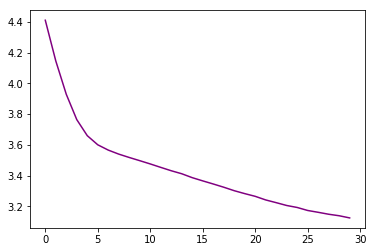

In [8]:
model = FHVAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # 0.001


losses = []
num_epochs = 30
for epoch in range(num_epochs):
    loss = train_single_epoch(model, optimizer, training_samples)
    losses.append(loss)
    if (epoch+1)%100==0:
        print(f'Epoch: {epoch}, Loss: {loss:.2f}')

# torch.save(model.state_dict(), f'fhvae_{num_epochs}.pth')
plt.plot(losses, color='purple')
plt.show()


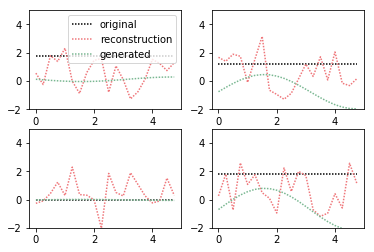

In [9]:
import tikzplotlib as tpl

fig, axes = plt.subplots(nrows=2,ncols=2)#,figsize=(14,5)

a =0
lines = []
for j in range(2):
    for i in range(2):
        r_index = np.random.randint(0,4)
        sequence_id = torch.LongTensor([0])
        y = training_samples[r_index].numpy()[0][0]
        p_x, p_z1, p_z2, mu2, x_reconstructed = model(training_samples[r_index], sequence_id=sequence_id)
        z1 = model.reparameterize(p_z1[0],p_z1[1]).data[0,0,0]
        z2 = model.reparameterize(p_z2[0],p_z2[1]).data[0,0,0]
        generated_sequence = z1.numpy() * np.sin(xs) + z2.numpy()

        y_reconstructed = x_reconstructed.squeeze().detach().numpy()
        l1, = axes[j][i].plot(xs, y,linestyle = (0, (1,1)), color = '#000000', label='original')
        l2, = axes[j][i].plot(xs, y_reconstructed,linestyle = (0, (1,1)), color = '#EF767A', label='reconstruction')
        l3, = axes[j][i].plot(xs, generated_sequence,linestyle = (0, (1,1)), color = '#79b791', label='generated')


        axes[j][i].set_ylim(-2,5)
        if (i==0) and (j==0):
            axes[j][i].legend()

        a += 1

# save es tex plot (does not need to look good here)
# tpl.save(
#     "../figures/sample_reconstructions.tex",
#     figure=fig,
#     axis_width="\\figwidth",
#     axis_height="\\figheight",
# #     ex_relative_path_to_data=".",
#     override_externals=True,
#     float_format=".3g",
# )

plt.show()
